# Align resulting depth map of Marigold with the COLMAP points

In [12]:
# Imports
import os
import json
import numpy as np
import torch
from scipy.interpolate import RegularGridInterpolator
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cv2
from PIL import Image

# Constants
# DATA_DIR = './../../scannetpp/4318f8bb3c'
DATA_DIR = './../../scannetpp/4318f8bb3c_downscaled'

TRAIN_COLOR_DIR = os.path.join(DATA_DIR, 'train/rgb')
TRAIN_DEPTH_DIR = os.path.join(DATA_DIR, 'train/depth')
MG_TRAIN_DIR = os.path.join(DATA_DIR, 'train/depth_MG')
MG_TRAIN_DIR_OUT = os.path.join(DATA_DIR, 'train/depth_MG_aligned')
MG_TRAIN_UNCERTAINTY_DIR = os.path.join(DATA_DIR, 'train/uncertainty_MG')
MG_TRAIN_UNCERTAINTY_DIR_OUT = os.path.join(DATA_DIR, 'train/uncertainty_MG_aligned')
MG_TEST_DIR = os.path.join(DATA_DIR, 'test/depth_MG')
COLORED_DEPTH_OUT = os.path.join(DATA_DIR, 'train/depth_MG_aligned_colored')
COLMAP_DIR = os.path.join(DATA_DIR, 'colmap')
COLMAP_TRAIN_DIR = os.path.join(COLMAP_DIR, 'sparse_train/0')
COLMAP_ALL_DIR = os.path.join(COLMAP_DIR, 'sparse/0')
POINT_CLOUDS_TRAIN_OUT = os.path.join(DATA_DIR, 'train/point_clouds_MG_aligned')
DENSE_DEPTH_PRIORS_POINT_CLOUDS_TRAIN_OUT = os.path.join(DATA_DIR, 'train/dense_depth_priors_point_clouds')
COLMAP_POINTS_TRAIN_OUT = os.path.join(DATA_DIR, 'train/colmap_point_cloud')
MASK_PATH = os.path.join(DATA_DIR, 'eval_mask.pth')
SENSOR_DEPTH_DIR = os.path.join(DATA_DIR, 'train/target_depth')
# SENSOR_DEPTH_SCALED_DIR = os.path.join(DATA_DIR, 'train/depth')
SENSOR_POINT_CLOUD_OUT = os.path.join(DATA_DIR, 'train/sensor_point_cloud')

In [13]:
# Create directories if needed
if not os.path.exists(MG_TRAIN_DIR_OUT):
    os.makedirs(MG_TRAIN_DIR_OUT)
if not os.path.exists(MG_TRAIN_UNCERTAINTY_DIR_OUT):
    os.makedirs(MG_TRAIN_UNCERTAINTY_DIR_OUT)
if not os.path.exists(COLORED_DEPTH_OUT):
    os.makedirs(COLORED_DEPTH_OUT)
if not os.path.exists(POINT_CLOUDS_TRAIN_OUT):
    os.makedirs(POINT_CLOUDS_TRAIN_OUT)
if not os.path.exists(DENSE_DEPTH_PRIORS_POINT_CLOUDS_TRAIN_OUT):
    os.makedirs(DENSE_DEPTH_PRIORS_POINT_CLOUDS_TRAIN_OUT)
if not os.path.exists(COLMAP_POINTS_TRAIN_OUT):
    os.makedirs(COLMAP_POINTS_TRAIN_OUT)
if not os.path.exists(SENSOR_POINT_CLOUD_OUT):
    os.makedirs(SENSOR_POINT_CLOUD_OUT)

In [14]:
def get_colmap_camera_matrix(colmap_cameras_path):
    with open(colmap_cameras_path, 'r') as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines if not line.startswith('#')]    # Skip all lines that begin with # (comments)
        # Extract image size:
        # CAMERA_ID, MODEL, WIDTH, HEIGHT, PARAMS[]
        image_size = tuple(map(int, lines[0].split(' ')[2:4]))
        # Extract the camera parameters
        camera_params = lines[0].split(' ')[-3:]
        # Extract the focal length and principal point
        f, cx, cy = map(float, camera_params)
        # Construct the camera matrix
        K = np.array([[f, 0, cx], [0, f, cy], [0, 0, 1]])
    return image_size, K

def get_colmap_dict_points(colmap_points_path):
    colmap_points_dict = {}
    with open(colmap_points_path, 'r') as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines if not line.startswith('#')]    # Skip all lines that begin with # (comments)
        for line in lines:
            line = line.strip().split()
            # 3D point list with one line of data per point:
            # POINT3D_ID, X, Y, Z, R, G, B, ERROR, TRACK[] as (IMAGE_ID, POINT2D_IDX)
            point_id = int(line[0])
            x = float(line[1])
            y = float(line[2])
            z = float(line[3])
            r = int(line[4])
            g = int(line[5])
            b = int(line[6])
            error = float(line[7])
            track = line[8:]
            for i in range(8, len(line), 2):
                image_id = int(line[i])
                point2d_idx = int(line[i + 1])
                track.append((image_id, point2d_idx))
            colmap_points_dict[point_id] = (x, y, z, r, g, b, error, track)
    return colmap_points_dict

def get_colmap_points(colmap_images_path, image_id):
    # Read the images.txt file which has the following format:
    #   IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID, NAME
    #   POINTS2D[] as (X, Y, POINT3D_ID)
    with open(colmap_images_path) as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines if not line.startswith('#')]    # Skip all lines that begin with # (comments)
        # Find the line corresponding to the image_id
        points_2d = []
        points_3d_ids = []
        q = None
        t = None
        for idx, line in enumerate(lines):
            if str(line).endswith(str(image_id) + '.JPG'):
                # Read the camera transformation
                q = list(map(float, lines[idx].split(' ')[1:5]))
                t = list(map(float, lines[idx].split(' ')[5:8]))
                # lines[idx+1] contains the POINTS2D[] line
                line_points = lines[idx+1].split(' ')
                # Read three elements at a time
                for i in range(0, len(line_points), 3):
                    x, y, point_3d_id = line_points[i:i+3]
                    if point_3d_id != '-1':
                        points_2d.append((float(x), float(y)))   # Return (y, x) to fit the image coordinates in numpy
                        points_3d_ids.append(int(point_3d_id))

    return q, t, points_2d, points_3d_ids

In [15]:
import numpy as np

def quaternion_to_rotation_matrix(q):
    """
    Convert a quaternion into a 3x3 rotation matrix.
    """
    qw, qx, qy, qz = q
    R = np.array([
        [1 - 2*qy**2 - 2*qz**2, 2*qx*qy - 2*qz*qw, 2*qx*qz + 2*qy*qw],
        [2*qx*qy + 2*qz*qw, 1 - 2*qx**2 - 2*qz**2, 2*qy*qz - 2*qx*qw],
        [2*qx*qz - 2*qy*qw, 2*qy*qz + 2*qx*qw, 1 - 2*qx**2 - 2*qy**2]
    ])
    return R

def rotation_traslation_to_matrix(R, t):
    """
    Convert a rotation matrix and a translation vector into a 4x4 transformation matrix.
    """
    Tr = np.eye(4)
    Tr[:3, :3] = R
    Tr[:3, 3] = t
    return Tr

def transform_points(points_3d, Tr):
    """
    Transform 3D points from world coordinates to camera coordinates.
    
    Parameters:
    points_3d : ndarray of shape (n, 3)
        The 3D points in world coordinates.
    T : ndarray of shape (4, 4)
        The transformation matrix from world to camera coordinates.
    Returns:
    points_3d_transformed : ndarray of shape (n, 3)
        The transformed 3D points in camera coordinates.
    """
    # Add a column of ones to the points_3d
    points_3d_homogeneous = np.hstack([points_3d, np.ones((points_3d.shape[0], 1))])
    # Transform the points
    points_3d_transformed = (Tr @ points_3d_homogeneous.T).T[:, :3]
    return points_3d_transformed

def compute_depth(points_3d_transformed):
    """
    Compute the depth values from the transformed 3D points.
    
    Parameters:
    points_3d_transformed : ndarray of shape (n, 3)
        The transformed 3D points in camera coordinates.
    
    Returns:
    depths : ndarray of shape (n,)
        The depth values (z-coordinates) of the transformed points.
    """
    return points_3d_transformed[:, 2]

In [16]:
def project_points(K, points_3d):
    """
    Project 3D points onto the image plane using the intrinsic matrix K.
    
    Parameters:
    K : ndarray of shape (3, 3)
        The intrinsic matrix.
    points_3d : ndarray of shape (n, 3)
        The 3D points in camera coordinates.
    
    Returns:
    points_2d : ndarray of shape (n, 2)
        The projected 2D points on the image plane.
    depths : ndarray of shape (n,)
        The depth values (z-coordinates) of the transformed points.
    """
    # Convert 3D points to homogeneous coordinates
    # points_3d_h = np.hstack([points_3d, np.ones((points_3d.shape[0], 1))])
    
    # Project to 2D (homogeneous coordinates)
    points_2d_h = (K @ points_3d.T).T
    
    # Convert to non-homogeneous coordinates
    points_2d = points_2d_h[:, :2] / points_2d_h[:, 2:]
    depths = points_3d[:, 2]  # Extract depth values (z-coordinates)
    
    return points_2d, depths

def filter_points_in_image(points_2d, depths, image_width, image_height):
    """
    Filter points to determine which ones lie within the camera plane.
    
    Parameters:
    points_2d : ndarray of shape (n, 2)
        The projected 2D points on the image plane.
    depths : ndarray of shape (n,)
        The depth values of the points.
    image_width : int
        The width of the image.
    image_height : int
        The height of the image.
    
    Returns:
    mask : ndarray of shape (n,)
        A boolean array indicating which points are within the image boundaries and in front of the camera.
    """
    mask = (
        (points_2d[:, 0] >= 0) & (points_2d[:, 0] < image_width) &  # x coordinates within image width
        (points_2d[:, 1] >= 0) & (points_2d[:, 1] < image_height) &  # y coordinates within image height
        (depths > 0)  # points in front of the camera
    )
    return mask


In [17]:
def interpolate_depth(depth_map, points_2d):
    # Define the grid coordinates
    y = np.arange(depth_map.shape[1])
    x = np.arange(depth_map.shape[0])

    # Create the interpolator object (we transpose because points_2d is (x, y) while depth_map is (y, x))
    interpolator = RegularGridInterpolator((x, y), depth_map)

    # Interpolate the depth values at the 2D points
    interpolated_depths = interpolator(points_2d)

    return interpolated_depths

def align_depth_map_with_3d_points(depth_map, points_2d, ground_truth_depths, points_error):
    # Interpolate the depth values at the 2D points
    depths = interpolate_depth(depth_map, points_2d)
    # print(f'MG_PREDICTION: {depths}')
    # print(f'COLMAP_GT: {ground_truth_depths}')
    print(f'Error before: {np.sqrt(np.mean((depths - ground_truth_depths)**2))}')

    # Reject outliers
    # inds1 = np.argsort(depths)
    # inds2 = np.argsort(ground_truth_depths)

    # mask = (np.abs(inds1 - inds2) < (depths.shape[0] // 4))  & (depths >= 0.1) & (depths <= 0.9)
    # ground_truth_depths = ground_truth_depths[mask]
    # points_error = points_error[mask]
    # depths = depths[mask]

    # Calculate the square root of the weights (use inverse error as weights and consider the relative error per point)
    #sqrt_weights = np.sqrt(1.0 / ((points_error ** 2))) # Note using the squared error (error ** 4 here) gives worse results
    if points_error == None:
        sqrt_weights = np.sqrt(1.0 / (ground_truth_depths ** 2))
    else:
        sqrt_weights = np.sqrt(1.0 / ((ground_truth_depths ** 2) * (points_error ** 4)))
    
    # Set up the weighted linear system: sqrt(W) * (A @ [a, b]) = sqrt(W) * depth_ground_truth_valid
    A = torch.tensor(np.vstack([depths, np.ones_like(depths)]).T, dtype=torch.float32)
    b = torch.tensor(ground_truth_depths, dtype=torch.float32)
    W = torch.tensor(np.diag(sqrt_weights), dtype=torch.float32)

    # Solve for the scale (a) and shift (b) parameters using the weighted system
    params = torch.linalg.inv(A.T @ W @ A) @ A.T @ W @ b
        
    # Extract scale and shift
    s, t = params
    s = s.numpy()
    t = t.numpy()

    # Compute the error
    error = np.sqrt(np.mean((s * depths + t - ground_truth_depths)**2))
    print(f'Error after: {error}')
    print(f'Scale : {s}, Shift: {t}')
    
    return s, t, error

In [18]:
def colorize_depth_maps(depth_map, min_depth, max_depth, cmap="Spectral"):
    """
    Colorize depth maps.
    """
    assert len(depth_map.shape) >= 2, "Invalid dimension"

    depth = depth_map.copy().squeeze()
    # reshape to [ (B,) H, W ]
    if depth.ndim < 3:
        depth = depth[np.newaxis, :, :]

    # colorize
    cm = matplotlib.colormaps[cmap]
    depth = ((depth - min_depth) / (max_depth - min_depth)).clip(0, 1)
    img_colored_np = cm(depth, bytes=False)[:, :, :, 0:3]  # value from 0 to 1
    img_colored_np = np.rollaxis(img_colored_np, 3, 1)

    return img_colored_np

def chw2hwc(chw):
    assert 3 == len(chw.shape)
    if isinstance(chw, np.ndarray):
        hwc = np.moveaxis(chw, 0, -1)
    return hwc

def get_colorized_depth_map(depth_pred, color_map="Spectral", valid_mask=None):
    min_depth = 0
    max_depth = 20
    depth_colored = colorize_depth_maps(depth_pred, min_depth, max_depth, cmap=color_map).squeeze()  # [3, H, W], value in (0, 1)
    depth_colored = (depth_colored * 255).astype(np.uint8)
    depth_colored_hwc = chw2hwc(depth_colored)
    depth_colored_img = Image.fromarray(depth_colored_hwc)
    return depth_colored_img

In [19]:
# Save point cloud to obj file
def save_point_cloud_to_obj(points, filename, colors=None):
    with open(filename  + '.obj', 'w') as f:
        for i in range(points.shape[0]):
            # Write the vertices with colors
            point = points[i, :]
            if colors is not None:
                color = colors[i, :]
                f.write('v %f %f %f %f %f %f\n' % (point[0], point[1], point[2], color[0], color[1], color[2]))
            else:
                f.write('v %f %f %f\n' % (point[0], point[1], point[2]))

def save_point_cloud(metric_depth_pred, image, K, camera_to_world, out_path, mask=None):
    # Prepare colors array
    if image is None:
        colors = np.zeros((metric_depth_pred.shape[0], 3))
    else:
        colors = image.reshape(-1, 3)

    # Create grid for the image plane
    FINAL_WIDTH, FINAL_HEIGHT = image.shape[1], image.shape[0]
    x, y = np.meshgrid(np.arange(FINAL_WIDTH), np.arange(FINAL_HEIGHT))

    # Normalize coordinates using the intrinsic matrix parameters
    focal_length_x = K[0, 0]
    focal_length_y = K[1, 1]
    c_x = K[0, 2]
    c_y = K[1, 2]
    x_normalized = (x - c_x) / focal_length_x
    y_normalized = (FINAL_HEIGHT - y - c_y) / focal_length_y

    # Depth values from resized_pred
    z = np.array(metric_depth_pred)
    # Calculate 3D points by unprojecting
    points = np.stack((np.multiply(x_normalized, z), np.multiply(y_normalized, z), -z), axis=-1).reshape(-1, 3)
    # Convert points to homogeneous coordinates
    points = np.hstack((points, np.ones((points.shape[0], 1))))
    # Convert points from camera coordinates to world coordinates
    points = camera_to_world.dot(points.T).T
    # Get (x, y, z) coordinates
    points = points[:, :3]
    if mask is not None:
        save_point_cloud_to_obj(points[mask], out_path, colors[mask])
    else:
        save_point_cloud_to_obj(points, out_path, colors)

    return points

In [20]:
def convert_depth_completion_scaling_to_m(depth):
    # convert from depth completion scaling to meter, that means map range 0 .. 1 to range 0 .. 16,38m
    return depth * (2 ** 16 - 1) / 4000.

def compute_rmse(prediction, target):
    return torch.sqrt((prediction - target).pow(2).mean())

def compute_l1(prediction, target):
    return torch.abs(prediction - target).mean()

def compute_std(prediction, target):
    return torch.std(prediction - target)

In [21]:
# Load JSON file
def load_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)
meta = load_json(os.path.join(DATA_DIR, 'transforms_train.json'))

In [22]:
dense_depth_priors_depths = torch.load(os.path.join(DATA_DIR, 'depths.pth'))
# Get camera matrix
image_size, K = get_colmap_camera_matrix(os.path.join(COLMAP_TRAIN_DIR, 'cameras.txt'))
image_width, image_height = image_size
# Get dictionary of points
points_dict = get_colmap_dict_points(os.path.join(COLMAP_TRAIN_DIR, 'points3D.txt'))
errors = []
rmse_erros = []
relative_depths = []
aligned_depths = []
uncertainties = []
aligned_uncertainties = []
colmap_depths = []
sensor_depths = []
valid_indexes = []

# Iterate over the depths in the directory
for i, meta_i in enumerate(meta['frames']): #os.listdir(MG_TRAIN_DIR)):
    filename = meta_i['file_path']
    filename = os.path.basename(filename).split('.')[0] + '.npy'
    if not filename.endswith('uncertainty.npy'):
        image_id = filename.split('.')[0]
        K[0, 0] = meta_i['fx']
        K[1, 1] = meta_i['fy']
        K[0, 2] = meta_i['cx']
        K[1, 2] = meta_i['cy']
        print(f'IMAGE {image_id}:')
        # Get relative depth from Marigold
        relative_depth = np.load(os.path.join(MG_TRAIN_DIR, filename))
        relative_depths.append(relative_depth)
        image = np.array(Image.open(os.path.join(DATA_DIR, meta_i['file_path']))) / 255.0
        # Invert the transformation matrix to get the camera-to-world matrix
        camera_to_world = np.array(meta_i['transform_matrix'])
        # Get points from COLMAP for the same image
        # LEGACY CODE FOR USING COLMAP POINTS
        # colmap_images_path = os.path.join(COLMAP_TRAIN_DIR, 'images.txt')
        # q, t, _, points_3d_ids = get_colmap_points(colmap_images_path, image_id)
        # points_3d = [points_dict[point_id] for point_id in points_3d_ids]
        # # Select the first three elements of the points_3d
        # points_3d_xyz = np.array([point[:3] for point in points_3d])
        # points_error = np.array([point[6] for point in points_3d])
        # # Transform the 3D points into camera coordinates
        # print(image_id)
        # Tr = rotation_traslation_to_matrix(quaternion_to_rotation_matrix(q), t)
        # if points_3d_xyz.shape[0] == 0:
        #     print(f'NO POINTS FOR IMAGE {image_id}')
        #     continue
        # points_3d_transformed = transform_points(np.array(points_3d_xyz)[:, :3], Tr)
        # # Sanity check. Project points and get depths
        # points_2d, depths = project_points(K, points_3d_transformed)
        # # Sanity check. Filter points within the image boundaries
        # mask = filter_points_in_image(points_2d, depths, image_width, image_height)
        # if mask.any() == False:
        #     # This should never happen if the points from COLMAP are correct
        #     print(f'WARNING, ALL COLMAP POINTS SHOULD LIE INSIDE THE IMAGE PLANE {image_id}')
        #     continue
        # END LEGACY CODE
        # Recover metric depth from the colmap points
        depth = np.array(Image.open(os.path.join(DATA_DIR, meta_i['depth_file_path'])), dtype=np.float64) / 1000.
        colmap_depths.append(depth)
        # depth = np.array(Image.open(os.path.join(SENSOR_DEPTH_DIR, filename.replace('.npy', '.png'))), dtype=np.float64) / 1000.0
        # # Set all except 1000 random points to 0
        # prob = 1000.0 / (depth.shape[0] * depth.shape[1])
        # mask = np.random.choice([True, False], size=depth.shape, p=[1-prob, prob])
        # depth[mask] = 0
        # colmap_depths.append(depth)
        # Get indexes for the pixels with actual depth
        points_2d = np.argwhere(depth > 0)

        if points_2d.shape[0] == 0:
            print(f'NO POINTS FOR IMAGE {image_id}')
            continue
        valid_indexes.append(i)
        # Get the depth values using indexes
        depths = depth[points_2d[:, 0], points_2d[:, 1]]
        print('Num points:', depths.shape)
        print('Max COLMAP depth:', depths.max())
        # Align the depth map with the 3D points
        s, t, error = align_depth_map_with_3d_points(relative_depth, points_2d, depths, None)  # TODO: check the points errors also
        errors.append(error)
        # Modify the depth map using the found scale and shift
        aligned_depth = s * relative_depth + t
        print(f'MAX DEPTH: {aligned_depth.max()}, MAX DEPTH GT: {depths.max()}')
        print(f'MIN DEPTH: {aligned_depth.min()}, MIN DEPTH GT: {depths.min()}')
        if aligned_depth.min() < 0:
            print(f'NEGATIVE DEPTH HERE: {filename}, ID: {i}')
        # Save the aligned depth map
        np.save(os.path.join(MG_TRAIN_DIR_OUT, filename), aligned_depth)
        # Scale the uncertainty values
        uncertainty_filename = filename.replace('.npy', '_uncertainty.npy')
        uncertainty = np.load(os.path.join(MG_TRAIN_UNCERTAINTY_DIR, uncertainty_filename))
        uncertainties.append(uncertainty)
        aligned_uncertainties.append(s * uncertainty)
        np.save(os.path.join(MG_TRAIN_UNCERTAINTY_DIR_OUT, uncertainty_filename), s * uncertainty)
        # Plot the depth map
        colored_save_path = os.path.join(COLORED_DEPTH_OUT, filename.replace('.npy', '.png'))
        if os.path.exists(colored_save_path):
            print(f"Existing file: '{colored_save_path}' will be overwritten")
        depth_colored = get_colorized_depth_map(aligned_depth)
        depth_colored.save(colored_save_path)
        # Unproject and save point cloud
        # save_point_cloud(aligned_depth, image, K, camera_to_world, os.path.join(POINT_CLOUDS_TRAIN_OUT, image_id))
        print('Max aligned:', aligned_depth.max())
        aligned_depths.append(aligned_depth)
        # Visualize COLMAP points
        # colors = np.zeros_like(points_3d_xyz)
        # colors[:, 0] = 1.0
        # save_point_cloud_to_obj(points_3d_xyz, os.path.join(COLMAP_POINTS_TRAIN_OUT, image_id), colors)
        # Load sensor depth and save it as a pointcloud
        sensor_depth = np.array(Image.open(os.path.join(SENSOR_DEPTH_DIR, filename.replace('.npy', '.png'))), dtype=np.float64) / 1000.0
        sensor_depth_mask = sensor_depth.flatten() > 0
        print('Max sensor:', sensor_depth.max())
        # save_point_cloud(sensor_depth, image, K, camera_to_world, os.path.join(SENSOR_POINT_CLOUD_OUT, image_id), sensor_depth_mask)
        print()
        print()

        # Save point cloud for dense depth priors
        # save_point_cloud(dense_depth_priors_depths[i].numpy(), image, K, camera_to_world, os.path.join(DENSE_DEPTH_PRIORS_POINT_CLOUDS_TRAIN_OUT, image_id))

IMAGE DSC08894:
Num points: (774,)
Max COLMAP depth: 3.724
Error before: 1.5163390428879568
Error after: 0.1837324231881933
Scale : 1.7195805311203003, Shift: 1.1289396286010742
MAX DEPTH: 2.848520278930664, MAX DEPTH GT: 3.724
MIN DEPTH: 1.1291972398757935, MIN DEPTH GT: 1.052
Existing file: './../../scannetpp/4318f8bb3c_downscaled/train/depth_MG_aligned_colored/DSC08894.png' will be overwritten
Max aligned: 2.8485203
Max sensor: 3.524


IMAGE DSC08914:
Num points: (835,)
Max COLMAP depth: 5.538
Error before: 2.3797371860411074
Error after: 0.19850072020713447
Scale : 4.023218154907227, Shift: 0.8392914533615112
MAX DEPTH: 4.862420558929443, MAX DEPTH GT: 5.538
MIN DEPTH: 0.8392914533615112, MIN DEPTH GT: 0.95
Existing file: './../../scannetpp/4318f8bb3c_downscaled/train/depth_MG_aligned_colored/DSC08914.png' will be overwritten
Max aligned: 4.8624206
Max sensor: 5.171


IMAGE DSC08930:
Num points: (1000,)
Max COLMAP depth: 5.607
Error before: 2.3403694070765395
Error after: 0.1965650

In [23]:
def load_ground_truth_depth(basedir, train_filenames, image_size, depth_scaling_factor):
    H, W = image_size
    gt_depths = []
    gt_valid_depths = []
    for filename in train_filenames:
        filename = filename.replace("rgb", "target_depth")
        if filename.endswith(".JPG"):
            filename = filename.replace(".JPG", ".png")
        elif filename.endswith(".jpg"):
            filename = filename.replace(".jpg", ".png")
        else:
            raise ValueError("Invalid filename")
        gt_depth_fname = os.path.join(basedir, filename)
        if os.path.exists(gt_depth_fname):
            gt_depth = np.array(Image.open(gt_depth_fname), dtype=np.float64)
            gt_valid_depth = gt_depth > 0.5
            gt_depth = (gt_depth / depth_scaling_factor).astype(np.float32)
        else:
            assert False
            gt_depth = np.zeros((H, W))
            gt_valid_depth = np.full_like(gt_depth, False)
        gt_depths.append(np.expand_dims(gt_depth, -1))
        gt_valid_depths.append(gt_valid_depth)
    gt_depths = np.stack(gt_depths, 0)
    gt_valid_depths = np.stack(gt_valid_depths, 0)
    return gt_depths, gt_valid_depths

# Get some visualization

In [24]:
valid_imgs = torch.tensor(list(range(0, len(meta['frames']))))
eval_mask = torch.load(MASK_PATH)[valid_imgs, :, :]
sensor_depth, _ = load_ground_truth_depth(DATA_DIR, [frame['file_path'] for frame in meta['frames']], (image_size[1], image_size[0]), 1000)
sensor_depth = torch.tensor(sensor_depth, dtype=torch.float32).squeeze()[valid_imgs, :, :]

In [25]:
# Rescale all aligned depths
for i in range(len(relative_depths)):
    relative_depths[i] = cv2.resize(relative_depths[i], (sensor_depth.shape[2], sensor_depth.shape[1]), cv2.INTER_AREA)
    aligned_depths[i] = cv2.resize(aligned_depths[i], (sensor_depth.shape[2], sensor_depth.shape[1]), cv2.INTER_AREA)
    uncertainties[i] = cv2.resize(uncertainties[i], (sensor_depth.shape[2], sensor_depth.shape[1]), cv2.INTER_AREA)
    aligned_uncertainties[i] = cv2.resize(aligned_uncertainties[i], (sensor_depth.shape[2], sensor_depth.shape[1]), cv2.INTER_AREA)

4.531


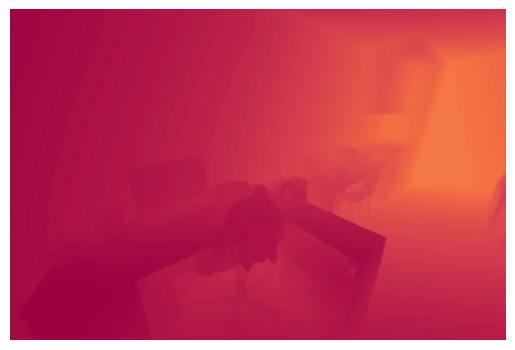

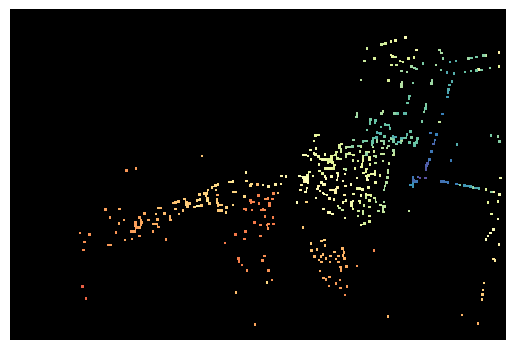

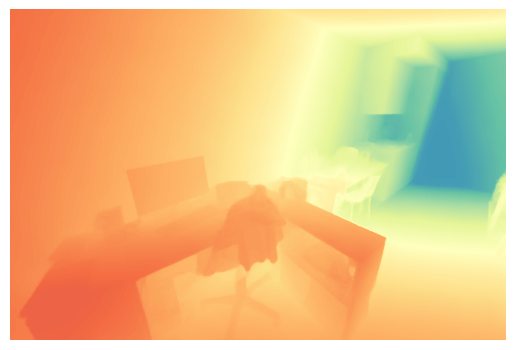

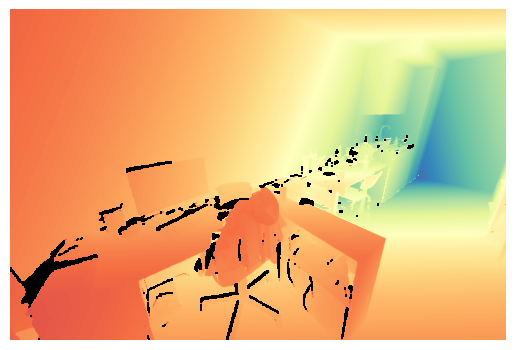

In [26]:
img_id = 13
# Calculate the max depth
max_depth = np.max([aligned_depths[img_id], relative_depths[img_id], sensor_depth[img_id].numpy(), colmap_depths[img_id]])
print(max_depth)

# Create a masked array where depth values of 0 are masked
masked_sensor_depth = np.ma.masked_where(sensor_depth[img_id].numpy() == 0, sensor_depth[img_id].numpy())
colmap_depth_dilated = cv2.dilate(colmap_depths[img_id], np.ones((7, 7)))
masked_colmap_depth = np.ma.masked_where(colmap_depth_dilated == 0, colmap_depth_dilated)
# Dilate a bit the points so they are more visible
# masked_colmap_depth = cv2.dilate(colmap_depths[img_id], np.ones((5, 5)))
# Display the image using the Spectral colormap and setting masked values to black
cmap = plt.cm.Spectral
cmap.set_bad(color='black')

plt.imshow(relative_depths[img_id] / max_depth, vmin=0.0, vmax=1.0, cmap=cmap)
plt.axis('off')
plt.show()
plt.imshow(masked_colmap_depth / max_depth, vmin=0.0, vmax=1.0, cmap=cmap)
plt.axis('off')
plt.show()
plt.imshow(aligned_depths[img_id] / max_depth, vmin=0.0, vmax=1.0, cmap=cmap)
plt.axis('off')
plt.show()
plt.imshow(masked_sensor_depth / max_depth, vmin=0.0, vmax=1.0, cmap=cmap)
plt.axis('off')
plt.show()

0.45556998


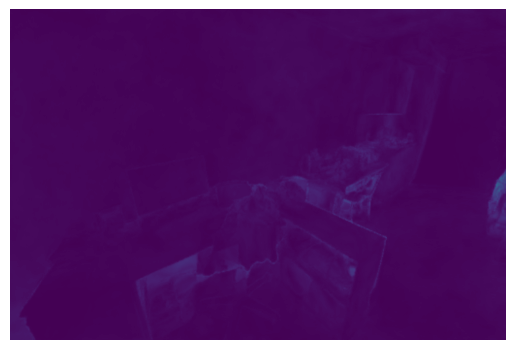

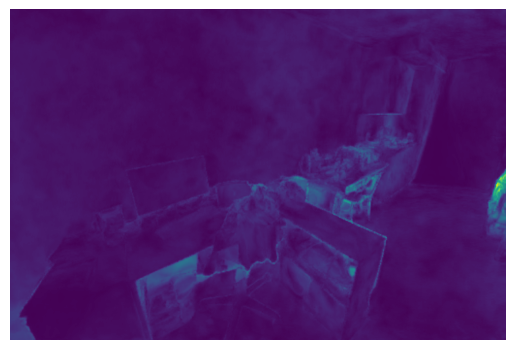

In [27]:
max_uncertainty = np.max([uncertainties[img_id], aligned_uncertainties[img_id]])
print(max_uncertainty)
cmap = plt.cm.viridis

plt.imshow(uncertainties[img_id] / max_uncertainty, vmin=0.0, vmax=1.0, cmap=cmap)
plt.axis('off')
plt.show()
plt.imshow(aligned_uncertainties[img_id] / max_uncertainty, vmin=0.0, vmax=1.0, cmap=cmap)
plt.axis('off')
plt.show()

4.4937687


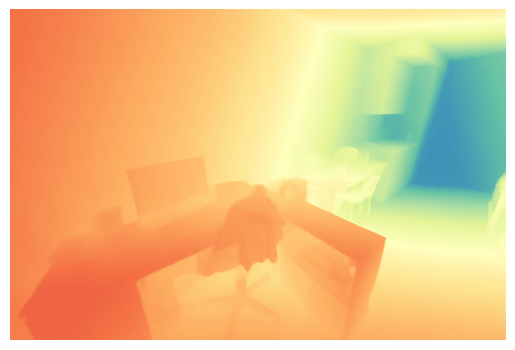

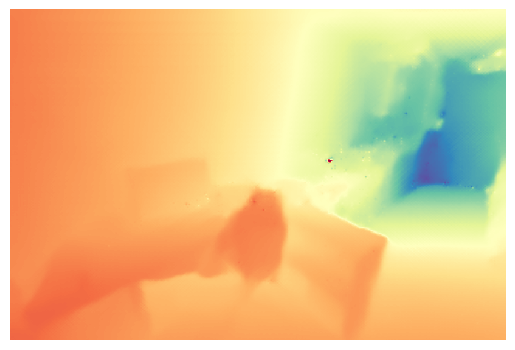

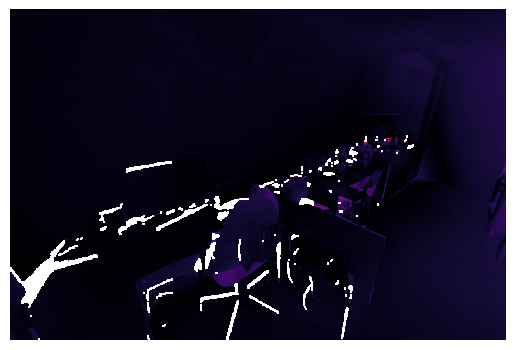

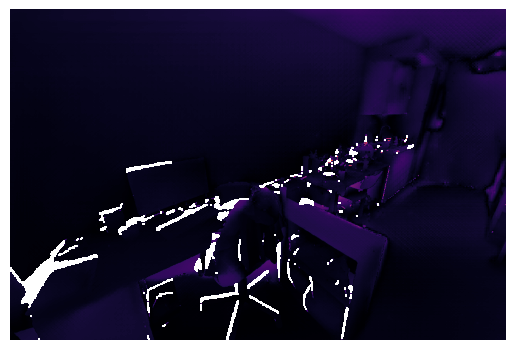

In [28]:
max_depth = np.max([aligned_depths[img_id], dense_depth_priors_depths[img_id].numpy()])
cmap = plt.cm.Spectral
print(max_depth)

plt.imshow(aligned_depths[img_id] / max_depth, vmin=0.0, vmax=1.0, cmap=cmap)
plt.axis('off')
plt.show()
plt.imshow(dense_depth_priors_depths[img_id].numpy() / max_depth, vmin=0.0, vmax=1.0, cmap=cmap)
plt.axis('off')
plt.show()

# Errors
plt.imshow(np.abs(masked_sensor_depth - aligned_depths[img_id]), cmap='inferno')
plt.axis('off')
plt.show()
plt.imshow(np.abs(masked_sensor_depth - dense_depth_priors_depths[img_id].numpy()), cmap='inferno')
plt.axis('off')
plt.show()

4.4937687


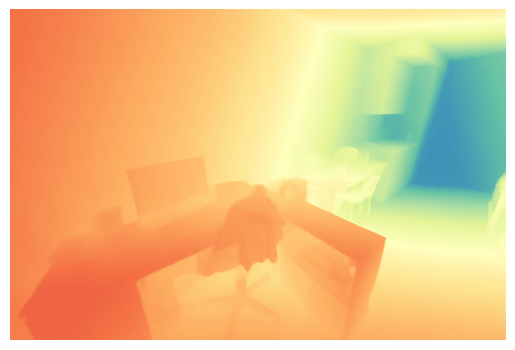

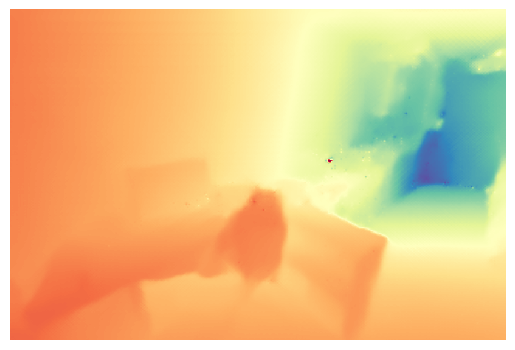

In [29]:
max_depth = np.max([aligned_depths[img_id], dense_depth_priors_depths[img_id].numpy()])
cmap = plt.cm.Spectral
print(max_depth)

plt.imshow(aligned_depths[img_id] / max_depth, vmin=0.0, vmax=1.0, cmap=cmap)
plt.axis('off')
plt.show()
plt.imshow(dense_depth_priors_depths[img_id].numpy() / max_depth, vmin=0.0, vmax=1.0, cmap=cmap)
plt.axis('off')
plt.show()

# Get errors

In [30]:
# Our errors
depths = torch.tensor(aligned_depths)[eval_mask]
gt_depths_train = sensor_depth[eval_mask]
print('rmse: ', compute_rmse(depths, gt_depths_train))
print('l1: ', compute_l1(depths, gt_depths_train))
print('std: ', compute_std(depths, gt_depths_train))

/var/folders/mz/h5vgbzmx1zn2p9ykvcgn5nmr0000gn/T/ipykernel_7491/2107583302.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  depths = torch.tensor(aligned_depths)[eval_mask]


rmse:  tensor(0.2201)
l1:  tensor(0.1627)
std:  tensor(0.1795)


In [31]:
# Original Dense Depth Priors errors
ddp_depths = torch.tensor(dense_depth_priors_depths[valid_imgs, :, :])[eval_mask]
gt_depths_train = sensor_depth.squeeze(-1)[eval_mask]

print('rmse: ', compute_rmse(ddp_depths, gt_depths_train))
print('l1: ', compute_l1(ddp_depths, gt_depths_train))
print('std: ', compute_std(ddp_depths, gt_depths_train))

/var/folders/mz/h5vgbzmx1zn2p9ykvcgn5nmr0000gn/T/ipykernel_7491/1879658546.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ddp_depths = torch.tensor(dense_depth_priors_depths[valid_imgs, :, :])[eval_mask]


rmse:  tensor(0.2488)
l1:  tensor(0.1869)
std:  tensor(0.1821)
